### Finansal Genellemelerin Analiz Edilmesi | Doğrusal Regresyon

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import missingno as msno

import scipy.stats
import statsmodels.api as sm

from termcolor import colored
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

#### Import Data

In [2]:
tickers = ["TRY=X", "EURTRY=X", "GBPTRY=X", "XU100.IS", "DAX", "GC=F", "^GSPC"]

start_date = '2015-01-01'

end_date = '2017-01-01'

panel_data = yf.download(tickers, start = start_date, end = end_date, progress = False)

panel_data.head()

Price       Adj Close                                                        \
Ticker            DAX EURTRY=X GBPTRY=X         GC=F    TRY=X      XU100.IS   
Date                                                                          
2015-01-01        NaN  2.82487   3.6379          NaN  2.33116           NaN   
2015-01-02  21.189384  2.81987   3.6338  1186.000000  2.33098  85458.898438   
2015-01-05  20.150284  2.79728   3.5788  1203.900024  2.34224  86462.601562   
2015-01-06  20.150284  2.78208   3.5559  1219.300049  2.33075  86909.601562   
2015-01-07  20.150284  2.75848   3.5162  1210.599976  2.32361  86776.601562   

Price                        Close                    ...     Open  \
Ticker            ^GSPC        DAX EURTRY=X GBPTRY=X  ...    TRY=X   
Date                                                  ...            
2015-01-01          NaN        NaN  2.82487   3.6379  ...  2.33116   
2015-01-02  2058.199951  26.163000  2.81987   3.6338  ...  2.33098   
2015-01-05  2020.579956  24.879999  2.79728   3.5788  ...  2.34224   
2015-01-06  2002.609985  24.879999  2.78208   3.5559  ...  2.33075   
2015-01-07  2025.900024  24.879999  2.75848   3.5162  ...  2.32474   

Price                                  Volume                                 \
Ticker          XU100.IS        ^GSPC     DAX EURTRY=X GBPTRY=X   GC=F TRY=X   
Date                                                                           
2015-01-01           NaN          NaN     NaN        0        0    NaN     0   
2015-01-02  85447.898438  2058.899902     0.0        0        0  138.0     0   
2015-01-05  85495.296875  2054.439941  2700.0        0        0  470.0     0   
2015-01-06  86650.898438  2022.150024     0.0        0        0   97.0     0   
2015-01-07  86925.101562  2005.550049   100.0        0        0   29.0     0   

Price                                  
Ticker         XU100.IS         ^GSPC  
Date                                   
2015-01-01          NaN           NaN  
2015-01-02  328037000.0  2.708700e+09  
2015-01-05  644588000.0  3.799120e+09  
2015-01-06  698321000.0  4.460110e+09  
2015-01-07  791949000.0  3.805480e+09  

[5 rows x 42 columns]

In [3]:
panel_data.shape

(522, 42)

In [4]:
df = panel_data["Close"].reset_index()

df.head()

Ticker,Date,DAX,EURTRY=X,GBPTRY=X,GC=F,TRY=X,XU100.IS,^GSPC
0,2015-01-01,NaN,2.82487,3.6379,NaN,2.33116,NaN,NaN
1,2015-01-02,26.163000,2.81987,3.6338,1186.000000,2.33098,85458.898438,2058.199951
2,2015-01-05,24.879999,2.79728,3.5788,1203.900024,2.34224,86462.601562,2020.579956
3,2015-01-06,24.879999,2.78208,3.5559,1219.300049,2.33075,86909.601562,2002.609985
4,2015-01-07,24.879999,2.75848,3.5162,1210.599976,2.32361,86776.601562,2025.900024


In [5]:
df.shape

(522, 8)

In [6]:
df.rename(columns = {"TRY=X"    : "USD_TRY",
                     "EURTRY=X" : "EUR_TRY",
                     "GBPTRY=X" : "GDP_TRY",
                     "XU100.IS" : "BIST100",
                     "DAX"      : "DAX",
                     "GC=F"     : "GOLD",
                     "^GSPC"    : "SP500"}, inplace = True)

df.head()

Ticker,Date,DAX,EUR_TRY,GDP_TRY,GOLD,USD_TRY,BIST100,SP500
0,2015-01-01,NaN,2.82487,3.6379,NaN,2.33116,NaN,NaN
1,2015-01-02,26.163000,2.81987,3.6338,1186.000000,2.33098,85458.898438,2058.199951
2,2015-01-05,24.879999,2.79728,3.5788,1203.900024,2.34224,86462.601562,2020.579956
3,2015-01-06,24.879999,2.78208,3.5559,1219.300049,2.33075,86909.601562,2002.609985
4,2015-01-07,24.879999,2.75848,3.5162,1210.599976,2.32361,86776.601562,2025.900024


#### NA Operations


In [7]:
df.isnull().sum()

Ticker
Date        0
DAX        18
EUR_TRY     0
GDP_TRY     0
GOLD       20
USD_TRY     0
BIST100    18
SP500      18
dtype: int64

In [8]:
df.fillna(method = 'bfill', inplace = True)

df.isnull().sum()

Ticker
Date       0
DAX        0
EUR_TRY    0
GDP_TRY    0
GOLD       0
USD_TRY    0
BIST100    0
SP500      0
dtype: int64

In [9]:
df.dropna(inplace = True)

df.isnull().sum()

Ticker
Date       0
DAX        0
EUR_TRY    0
GDP_TRY    0
GOLD       0
USD_TRY    0
BIST100    0
SP500      0
dtype: int64

#### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()

In [12]:
y = df["BIST100"]

x = df[["USD_TRY", "DAX", "GOLD", "SP500"]]

In [13]:
model_lr = model.fit(x, y)

In [14]:
model_lr.intercept_

65251.7493764357

In [15]:
# USD_TRY'deki 1 birimlik artış, BIST100 hissesinde ortalama 14041 birimlik bir azalışa tekabül edebilir.

print(-1.40410419e+04)

-14041.0419


In [16]:
print(f'Coefficients: {model_lr.coef_}')

print(f'Intercept: {model_lr.intercept_}')

print(f'R^2 Score: {model_lr.score(x, y)}')

Coefficients: [-1.40410419e+04  1.95705822e+02  4.99063206e+00  2.07073288e+01]
Intercept: 65251.7493764357
R^2 Score: 0.6798458012958984


**Not:** R^2 değeri, bizim model içerisine koyduğumuz bağımsız değişkenlerin bağımlı değişken üzerindeki açıklayıcılığını ifade etmektedir.  

#### Data Splitting

In [17]:
df.reset_index(inplace = True)

In [18]:
df.head()

Ticker,index,Date,DAX,EUR_TRY,GDP_TRY,GOLD,USD_TRY,BIST100,SP500
0,0,2015-01-01,26.163000,2.82487,3.6379,1186.000000,2.33116,85458.898438,2058.199951
1,1,2015-01-02,26.163000,2.81987,3.6338,1186.000000,2.33098,85458.898438,2058.199951
2,2,2015-01-05,24.879999,2.79728,3.5788,1203.900024,2.34224,86462.601562,2020.579956
3,3,2015-01-06,24.879999,2.78208,3.5559,1219.300049,2.33075,86909.601562,2002.609985
4,4,2015-01-07,24.879999,2.75848,3.5162,1210.599976,2.32361,86776.601562,2025.900024


In [19]:
df.shape

(522, 9)

In [20]:
y = df["BIST100"]

x = df[["USD_TRY", "DAX", "GOLD", "SP500"]]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [22]:
df.shape

(522, 9)

In [23]:
x_train.shape

(349, 4)

In [24]:
y_test.shape

(173,)

In [25]:
model_lr_2 = model.fit(x_train, y_train)

pred = model_lr_2.predict(x_test)

pred 

array([79835.73840821, 80734.24887803, 85768.46414087, 74527.38331885,
       82224.1372637 , 74500.1869276 , 72770.94110679, 76758.24719101,
       81278.27023342, 82020.69775322, 85457.83658815, 74106.15891588,
       82323.14532534, 80194.2470493 , 76821.35817366, 82716.71710102,
       84476.29165679, 79738.20367666, 79066.57369113, 81026.6202678 ,
       76720.25548105, 73225.2296183 , 72901.31791559, 72447.11062726,
       73454.41419691, 73482.21159241, 76105.03075707, 78044.33669879,
       80150.59808842, 73937.49952617, 73286.94445532, 83348.08951937,
       78090.81046664, 79055.95916823, 84549.32956827, 82620.14196512,
       78715.0683124 , 83662.13328422, 85494.81543483, 82402.67530361,
       84170.77067323, 83264.92635084, 72004.94989403, 80616.43140376,
       72735.53896995, 73693.00198598, 83109.94535613, 77069.13019674,
       77722.77113757, 82331.87038379, 73260.59506655, 81894.41330725,
       80303.47964374, 72809.6231473 , 79445.77343955, 77727.50119381,
      

In [26]:
comp_data = pd.DataFrame({"Obs": y_test, "Pred": pred})

comp_data.head()

,Obs,Pred
434,75967.601562,79835.738408
440,77843.500000,80734.248878
6,87648.398438,85768.464141
184,74149.500000,74527.383319
78,84277.703125,82224.137264


Aşağıdaki Boxplot'dan yani kutu grafiğinden de gözlemleneceği üzere, tahmin edilen değerler, gerçekleşen değerlere göre daha basıktır, yani tahmin edilen değerler, gerçekleşen değerlere göre daha küçük bir aralıkta dağılmıştır.

<Axes: >

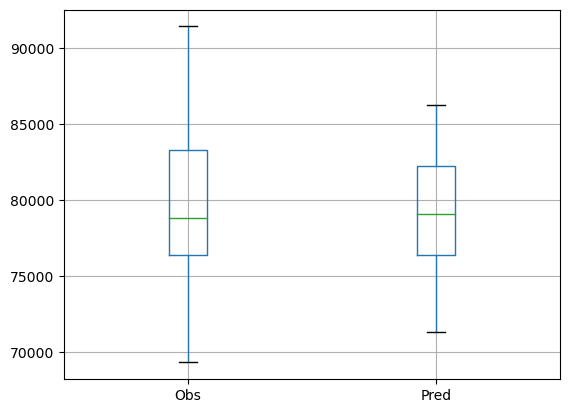

In [27]:
comp_data.boxplot(column = ["Obs", "Pred"])

Gerçek gözlem değerlerinden, tahmin edilen değerleri çıkararak **hata (error)** değerlerine ulaşıyoruz.

In [28]:
comp_data["Error"] = comp_data["Obs"] - comp_data["Pred"]

comp_data.head()

,Obs,Pred,Error
434,75967.601562,79835.738408,-3868.136846
440,77843.500000,80734.248878,-2890.748878
6,87648.398438,85768.464141,1879.934297
184,74149.500000,74527.383319,-377.883319
78,84277.703125,82224.137264,2053.565861


In [29]:
# Data içerisindeki en kötü %25'lik hata değerine ulaşmak istersek:

np.percentile(comp_data["Error"], 25)

-1205.3238414280495

In [30]:
lower = np.percentile(comp_data["Error"], 10)

upper = np.percentile(comp_data["Error"], 90)

In [31]:
comp_data["Error_Class"] = [2 if v > upper else 1 if v < lower else 0 for v in comp_data["Error"]]

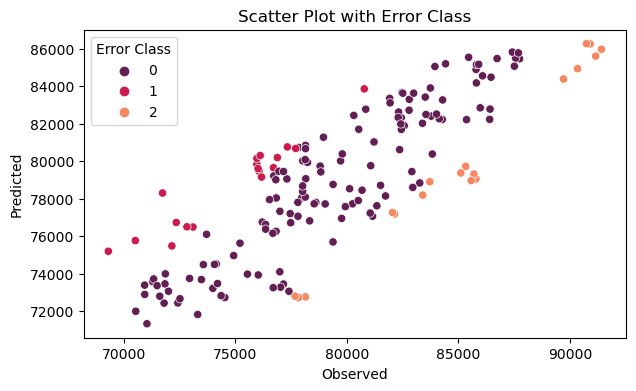

In [32]:
# Error_Class sütunu kategorik bir değişkene dönüştürüldü.

comp_data["Error_Class"] = pd.Categorical(comp_data["Error_Class"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data, x = "Obs", y = "Pred", hue = "Error_Class", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

In [33]:
x.head()

Ticker,USD_TRY,DAX,GOLD,SP500
0,2.33116,26.163000,1186.000000,2058.199951
1,2.33098,26.163000,1186.000000,2058.199951
2,2.34224,24.879999,1203.900024,2020.579956
3,2.33075,24.879999,1219.300049,2002.609985
4,2.32361,24.879999,1210.599976,2025.900024


In [34]:
# veriyi normalize etmek veya durağan hale getirmek için fark alma yani diff() işlemi yapıyoruz.

x.diff().head() 

Ticker,USD_TRY,DAX,GOLD,SP500
0,NaN,NaN,NaN,NaN
1,-0.00018,0.000000,0.000000,0.000000
2,0.01126,-1.283001,17.900024,-37.619995
3,-0.01149,0.000000,15.400024,-17.969971
4,-0.00714,0.000000,-8.700073,23.290039


In [35]:
x_d = x.diff().dropna()
y_d = y.diff().dropna()

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x_d, y_d, test_size = 0.33, random_state = 42)

In [37]:
model_d = LinearRegression()

In [38]:
model_lr_d = model_d.fit(x_train, y_train)
pred_d = model_lr_d.predict(x_test)

In [39]:
comp_data_d = pd.DataFrame({"Obs_d": y_test, "Pred_d": pred_d})

comp_data_d.head()

,Obs_d,Pred_d
508,755.695312,749.072150
94,1054.000000,401.172449
7,216.304688,-37.328084
246,-2073.906250,-661.044729
91,1489.695312,822.385005


In [40]:
comp_data_d["Error_d"] = comp_data_d["Obs_d"] - comp_data_d["Pred_d"]

comp_data_d.head()

,Obs_d,Pred_d,Error_d
508,755.695312,749.072150,6.623162
94,1054.000000,401.172449,652.827551
7,216.304688,-37.328084,253.632772
246,-2073.906250,-661.044729,-1412.861521
91,1489.695312,822.385005,667.310308


In [41]:
lower_d = np.percentile(comp_data_d["Error_d"], 10)

upper_d = np.percentile(comp_data_d["Error_d"], 90)

In [42]:
(lower_d, upper_d)

(-1239.3972470061808, 1140.5890443289268)

In [43]:
comp_data_d["Error_Class_d"] = [2 if v > upper_d else 1 if v < lower_d else 0 for v in comp_data_d["Error_d"]]

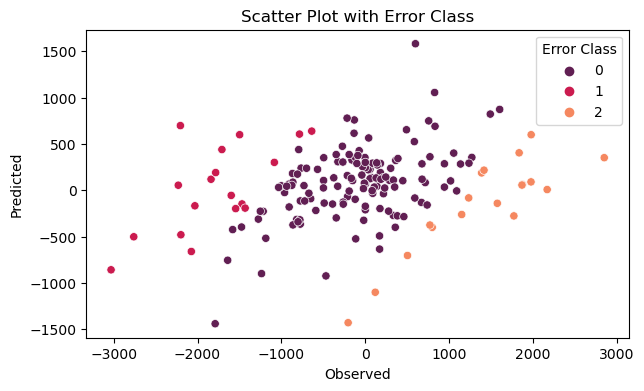

In [44]:
# Error_Class_d sütunu kategorik bir değişkene dönüştürüldü.

comp_data_d["Error_Class_d"] = pd.Categorical(comp_data_d["Error_Class_d"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data_d, x = "Obs_d", y = "Pred_d", hue = "Error_Class_d", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

In [45]:
def OLS_assumption_controller(model, x_train_data, y_train_data):
    
    yhat = model.predict(x_train_data)
    df = pd.DataFrame({"Actual": y_train_data, "Predicted": yhat})
    df["Residuals"] = abs(df["Actual"]) - abs(df["Predicted"])
    
    print("Anderson Darling Normality Test -------------------")
    p_norm = normal_ad(df["Residuals"])[1]
    if p_norm < 0.05:
        print(colored("Residuals are not normally distributed", "red", attrs = ["bold"]))
    else:
        print(colored("Residuals are normally distributed", "green", attrs = ["bold"]))
    print("\n")
    
    
    print("Variance Inflation Factor for Multicollinearity Test -----")
    
    VIF = [variance_inflation_factor(x_train_data.values, i) for i in range(x_train_data.shape[1])]
    
    for idx, vif in enumerate(VIF):
        if vif < 10:
            print(colored("{0}: {1}".format(x_train_data.columns[idx], vif), "green", attrs = ["bold"]))
        else:
            print(colored("{0}: {1}".format(x_train_data.columns[idx], vif), "red", attrs = ["bold"]))
    
    print("\n")
    
    print("Durbin Watson Autocorrelation Test -----------------")
    
    durbinWatson = durbin_watson(df["Residuals"])
    
    if 1.5 < durbinWatson < 2.5:
        print(colored("There is no autocorrelation in the resiuals", "green", attrs = ["bold"]))
    else:
        print(colored("There is an autocorrelation in the resiuals", "red", attrs = ["bold"]))
              
    print("\n")
              
    
    print("Breusch-Pagan Heteroskedasticity Test ----------")
    bp_test = het_breuschpagan(df["Residuals"], x_train_data)
    if bp_test[1] < 0.05:
        print(colored("The model is heteroskedastic.", "red", attrs = ["bold"]))
    else:
        print(colored("The model is not heteroskedastic.", "green", attrs = ["bold"]))


In [46]:
OLS_assumption_controller(model_lr_2, x_train, y_train)

Anderson Darling Normality Test -------------------
Residuals are not normally distributed


Variance Inflation Factor for Multicollinearity Test -----
USD_TRY: 1.0231515544115606
DAX: 1.9844751889753196
GOLD: 1.0576095946671757
SP500: 1.9761277786538196


Durbin Watson Autocorrelation Test -----------------
There is an autocorrelation in the resiuals


Breusch-Pagan Heteroskedasticity Test ----------
The model is not heteroskedastic.


#### KAYNAKLAR

[1] Mustafa Nayansak, Veri Bilimi Okulu, Python ile Finansal Veri Analizi: